### Notes
2. Remove extreme outlier timestamps for better classification accuracy
3. Handle backspace and delete correctly. Handle it independently of which key was used to delete characters

In [9]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyxhook
import time
from sklearn import svm

current_milli_time = lambda: int(round(time.time() * 1000))

In [10]:
number_of_samples = 50
number_of_keys = 8

In [11]:
def get_consecutive_diff(input_arr):
    temp = []
    for x in range(0, len(input_arr)-1):
        temp.append(input_arr[x+1] - input_arr[x])
    return temp
    
def get_arr_diff(down_events, up_events):
    assert len(down_events) == len(up_events)
    temp = []
    for x in range(0, len(down_events)):
        temp.append(up_events[x]-down_events[x])
    return temp

def parse_data(data, raw_data=False):
    up_arr = [x[1] for x in data['key_up_events']]
    down_arr = [x[1] for x in data['key_down_events']]
    
    # strip out the last few keys
    up_arr = up_arr[0:number_of_keys]
    down_arr = down_arr[0:number_of_keys]
    
    assert len(up_arr) == len(down_arr) == number_of_keys
    
    if raw_data:
        return (up_arr, down_arr)
    
    up_up_arr = get_consecutive_diff(up_arr)
    down_down_arr = get_consecutive_diff(down_arr)
    down_up_arr = get_arr_diff(down_arr, up_arr)
    
    return (up_up_arr, down_down_arr, down_up_arr)

def get_data(sample_number, raw_data=False):   
    f = 'samples/sample_' + str(sample_number) + '.pickle'
    data = pickle.load(open(f,'rb'))
    return parse_data(data, raw_data)
    
def sample_dist(sample_val, mean, std_dev):
    return (sample_val - mean)/float(std_dev)

## Reading Data

In [12]:
mean_list = []
std_dev_list = []

up_up_data = []
down_down_data = []
down_up_data = []

for i in range(1, number_of_samples+1):
    (up_up_arr, down_down_arr, down_up_arr) = get_data(i)
    up_up_data.append(up_up_arr)
    down_down_data.append(down_down_arr)
    down_up_data.append(down_up_arr)

## Calculating Statistics

In [13]:
up_up_mean_list = []
up_up_std_dev_list = []

df = pd.DataFrame(up_up_data, 
                  index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                  columns=['key_' + str(x) for x in range(1, number_of_keys)])
for key in list(df.columns.values):
    up_up_mean_list.append(np.mean(df[key]))
    up_up_std_dev_list.append(np.std(df[key]))    
df

,key_1,key_2,key_3,key_4,key_5,key_6,key_7
sample_1,47,154,135,185,111,57,183
sample_2,40,144,144,209,95,48,169
sample_3,37,178,153,191,112,64,176
sample_4,72,192,153,223,89,79,192
sample_5,56,152,136,169,111,49,159
sample_6,48,160,161,207,49,120,191
sample_7,55,176,144,329,127,72,192
sample_8,47,169,143,313,167,48,201
sample_9,48,160,144,185,615,72,200
sample_10,30,161,120,209,111,40,264


In [14]:
down_down_mean_list = []
down_down_std_dev_list = []

df = pd.DataFrame(down_down_data, 
                  index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                  columns=['key_' + str(x) for x in range(1, number_of_keys)])
for key in list(df.columns.values):
    down_down_mean_list.append(np.mean(df[key]))
    down_down_std_dev_list.append(np.std(df[key]))
df

,key_1,key_2,key_3,key_4,key_5,key_6,key_7
sample_1,121,159,120,168,96,93,139
sample_2,88,184,112,168,101,67,168
sample_3,113,159,152,168,104,89,151
sample_4,89,199,144,176,120,93,155
sample_5,100,156,136,160,80,64,160
sample_6,112,152,152,177,71,104,183
sample_7,113,167,160,296,120,93,155
sample_8,108,180,120,312,144,64,169
sample_9,89,151,152,168,592,89,175
sample_10,80,145,111,200,144,24,232


In [15]:
down_up_mean_list = []
down_up_std_dev_list = []

df = pd.DataFrame(down_up_data, 
                  index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                  columns=['key_' + str(x) for x in range(1, number_of_keys+1)]) # since down_up data has one extra 
for key in list(df.columns.values):
    down_up_mean_list.append(np.mean(df[key]))
    down_up_std_dev_list.append(np.std(df[key]))
df

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8
sample_1,119,45,40,55,72,87,51,95
sample_2,111,63,23,55,96,90,71,72
sample_3,112,36,55,56,79,87,62,87
sample_4,87,70,63,72,119,88,74,111
sample_5,95,51,47,47,56,87,72,71
sample_6,111,47,55,64,94,72,88,96
sample_7,112,54,63,47,80,87,66,103
sample_8,104,43,32,55,56,79,63,95
sample_9,87,46,55,47,64,87,70,95
sample_10,112,62,78,87,96,63,79,111


## Validating a Single Outside Sample

In [16]:
def get_scores(up_up_sample, down_down_sample, down_up_sample):
    
    up_up_score = 0
    down_down_score = 0
    down_up_score = 0

    for i in range(0, len(up_up_sample)):
        up_up_score = up_up_score + sample_dist(up_up_sample[i], up_up_mean_list[i], up_up_std_dev_list[i])
    
    for i in range(0, len(down_down_sample)):
        down_down_score = down_down_score + sample_dist(down_down_sample[i], down_down_mean_list[i], down_down_std_dev_list[i])
    
    for i in range(0, len(down_up_sample)):
        down_up_score = down_up_score + sample_dist(down_up_sample[i], down_up_mean_list[i], down_up_std_dev_list[i])
    
    up_up_score = up_up_score/number_of_samples
    down_down_score = down_down_score/number_of_samples
    down_up_score = down_up_score/number_of_samples
    
    return (up_up_score, down_down_score, down_up_score)    

In [17]:
up_up_valid_scores = []
down_down_valid_scores = []
down_up_valid_scores = []

for  i in range(0, number_of_samples):

    (up_up_sample, down_down_sample, down_up_sample) = get_data(i)
    (up_up_score, down_down_score, down_up_score) = get_scores(up_up_sample, down_down_sample,down_up_sample)

    #print 'Up up score:', up_up_score
    #print 'Down down score:', down_down_score
    #print 'Down up score:', down_up_score
    #print ''
    
    up_up_valid_scores.append(up_up_score)
    down_down_valid_scores.append(down_down_score)
    down_up_valid_scores.append(down_up_score)

In [28]:
maximum_number_of_std_deviations_from_mean = 3

up_up_threshold = np.mean(up_up_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(up_up_valid_scores)
down_down_threshold = np.mean(down_down_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(down_down_valid_scores)
down_up_threshold = np.mean(down_up_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(down_up_valid_scores)

print 'WARNING: thresholding on number of standard deviations from mean is inaccurate. Use a SVM!'
print 'Up up threshold:', up_up_threshold
print 'Down Down threshold:', down_down_threshold
print 'Down Up threshold:', down_up_threshold

Up up threshold: 0.168256860628
Down Down threshold: 0.165637332243
Down Up threshold: 0.224080518138


## Reading and Evaluating Amazon Mechanical Turk Samples

In [19]:
up_up_intruder_scores = []
down_down_intruder_scores = []
down_up_intruder_scores = []

data = pd.read_csv('live_samples/keyboard_events.csv')
for idx, row in data.iterrows():
    up_events_str = row['up_events']
    down_events_str = row['down_events']
    
    up_arr = [int(x) for x in up_events_str.split(',')]
    down_arr = [int(x) for x in down_events_str.split(',')]
    
    up_up_arr = get_consecutive_diff(up_arr)
    down_down_arr = get_consecutive_diff(down_arr)
    down_up_arr = get_arr_diff(down_arr, up_arr)
    
    (up_up_score, down_down_score, down_up_score) = get_scores(up_up_arr, down_down_arr, down_up_arr)
    
    #print 'Up up score:', up_up_score
    #print 'Down down score:', down_down_score
    #print 'Down up score:', down_up_score
    #print ''
    
    up_up_intruder_scores.append(up_up_score)
    down_down_intruder_scores.append(down_down_score)
    down_up_intruder_scores.append(down_up_score)
    

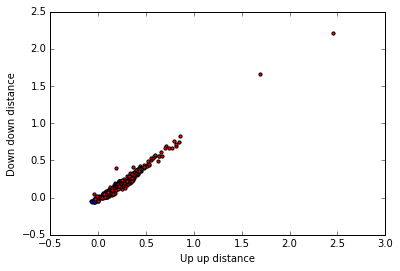

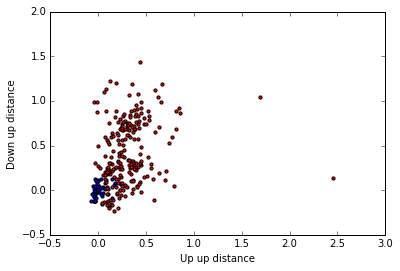

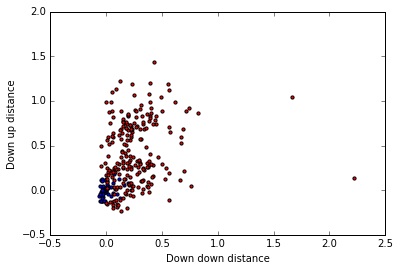

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(up_up_valid_scores, down_down_valid_scores, s=10, c='b', marker="o", label='valid')
ax1.scatter(up_up_intruder_scores, down_down_intruder_scores, s=10, c='r', marker="o", label='intruder')
plt.xlabel('Up up distance')
plt.ylabel('Down down distance')
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.scatter(up_up_valid_scores, down_up_valid_scores, s=10, c='b', marker="o", label='valid')
ax2.scatter(up_up_intruder_scores, down_up_intruder_scores, s=10, c='r', marker="o", label='intruder')
plt.xlabel('Up up distance')
plt.ylabel('Down up distance')
plt.show()

fig = plt.figure()
ax3 = fig.add_subplot(111)
ax3.scatter(down_down_valid_scores, down_up_valid_scores, s=10, c='b', marker="o", label='valid')
ax3.scatter(down_down_intruder_scores, down_up_intruder_scores, s=10, c='r', marker="o", label='intruder')
plt.xlabel('Down down distance')
plt.ylabel('Down up distance')
plt.show()

## Validating Live Sample from Local Computer

In [21]:
hookman = pyxhook.HookManager()

curr_str = []
up_events = []
down_events = []
times = 50

def record_event(event, prefix):
    global curr_str
    
    if event.Key == 'BackSpace' and prefix == 'KeyUp:':
        if len(curr_str) > 0:
            curr_str.pop()
            up_events.pop()
            down_events.pop()
            return
    if not event.Ascii >= 48 and event.Ascii <= 57 and \
       not event.Ascii >= 65 and event.Ascii <= 90 and \
       not event.Ascii >= 97 and event.Ascii <= 122:
        return
    
    if prefix == 'KeyDown:':
        down_events.append([event.Key, current_milli_time()])
    elif prefix == 'KeyUp:':
        up_events.append([event.Key, current_milli_time()])
        curr_str.append(event.Key)
        
def kb_down_event(event):
    record_event(event, 'KeyDown:')

def kb_up_event(event):
    record_event(event, 'KeyUp:')

    if event.Ascii == 32:
        global sample_number
        global curr_str
        global up_events
        global down_events
        global times

        if ''.join(curr_str) == 'password':
            data = dict()
            data['key_down_events'] = down_events
            data['key_up_events'] = up_events
            (up_up_arr, down_down_arr, down_up_arr) = parse_data(data)
            (up_up_score, down_down_score, down_up_score) = get_scores(up_up_arr, down_down_arr, down_up_arr)
            
            print 'Up up score:', up_up_score
            print 'Down down score:', down_down_score
            print 'Down up score:', down_up_score
            
            if up_up_score <= up_up_threshold and down_down_score <= down_down_threshold and down_up_score <= down_up_threshold:
                print 'True'
            else:
                print 'False'
                
            print ''
                
            times = times-1
            if times <= 0:              
                hookman.cancel()
                
        else:
            print 'Incorrect string. Skipping...'
            print curr_str
            
        # clear all variables after space
        curr_str = []
        up_events = []
        down_events = []

hookman.KeyDown = kb_down_event
hookman.KeyUp = kb_up_event

hookman.HookKeyboard()
hookman.start()

RECORD extension version 1.13
Incorrect string. Skipping...
['g', 'e', 'd', 'i', 't', 'p', 'a', 's', 's', 'w', 'o', 'r', 'd']
Up up score: -0.0672300466168
Down down score: -0.0442305231462
Down up score: 0.0689707592041
True

Up up score: -0.0672379618863
Down down score: -0.0256007082455
Down up score: 0.0225675040608
True

Up up score: -0.0597373010959
Down down score: -0.0239056100341
Down up score: 0.0495303348886
True

Up up score: 0.0319778003691
Down down score: 0.0482256697354
Down up score: 0.000242288867546
True

Up up score: -0.0722881598026
Down down score: -0.0562918649553
Down up score: -0.00619759361341
True

Up up score: 0.0116019720388
Down down score: 0.0334855527857
Down up score: 0.186468727202
True

Up up score: -0.101709619552
Down down score: -0.0540733054023
Down up score: 0.01362469517
True

Up up score: -0.0339638975293
Down down score: -0.0364602654489
Down up score: 0.029452306969
True

Up up score: -0.0908883021785
Down down score: -0.0537049655047
Down up

## Potential Bugs
1. Backspace
2. Go to middle, delete key and retype
3. Type half the password, wait a long while. Type the other half.

## Solutions
1. When backspace or any other text modification method is used, solution is to to use a simpler classifier trained on down-up scores. This will reduce complexity at the expense of some accuracy

## Reading and Evaluating Amazon Mechanical Turk Samples with SVM

In [13]:
up_up_data = up_up_valid_scores + up_up_intruder_scores
down_down_data = down_down_valid_scores + down_down_intruder_scores
down_up_data = down_up_valid_scores + down_up_intruder_scores

kernel = 'rbf'
h = .01 # step size in the mesh
C = 5  # SVM regularization parameter
gamma = 30 # SVM gamma

(-1.0605270162911473, 3.2094729837088565)

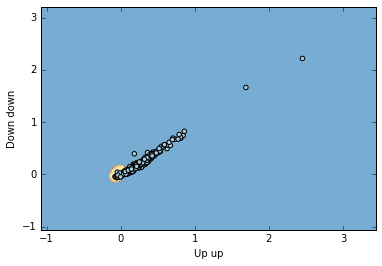

In [14]:
X = np.array((up_up_data, down_down_data)).transpose()
y = list(np.ones(len(up_up_valid_scores))) + list(np.zeros(len(up_up_intruder_scores)))

svc = svm.SVC(kernel=kernel, gamma=gamma, C=C).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Up up')
plt.ylabel('Down down')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.2371586984346152, 2.4228413015653878)

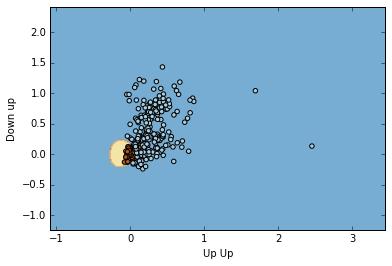

In [15]:
X = np.array((up_up_data, down_up_data)).transpose()
y = list(np.ones(len(up_up_valid_scores))) + list(np.zeros(len(up_up_intruder_scores)))

svc = svm.SVC(kernel=kernel, gamma=gamma, C=C).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Up Up')
plt.ylabel('Down up')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

(-1.2371586984346152, 2.4228413015653878)

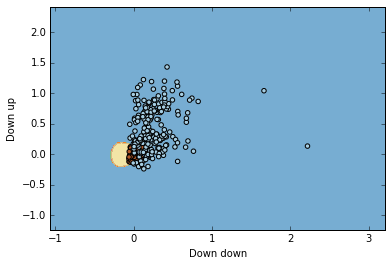

In [16]:
X = np.array((down_down_data, down_up_data)).transpose()
y = list(np.ones(len(down_down_valid_scores))) + list(np.zeros(len(down_down_intruder_scores)))

svc = svm.SVC(kernel=kernel, gamma=gamma, C=C).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Down down')
plt.ylabel('Down up')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## Combined SVM

In [17]:
up_up_data = up_up_valid_scores + up_up_intruder_scores
down_down_data = down_down_valid_scores + down_down_intruder_scores
down_up_data = down_up_valid_scores + down_up_intruder_scores

kernel = 'rbf'
h = .01 # step size in the mesh
C = 5  # SVM regularization parameter
gamma = 30 # SVM gamma

In [18]:
X = np.array((up_up_data, down_down_data, down_up_data)).transpose()
y = list(np.ones(len(up_up_valid_scores))) + list(np.zeros(len(up_up_intruder_scores)))

svc = svm.SVC(kernel=kernel, gamma=gamma, C=C).fit(X, y)

In [8]:
hookman = pyxhook.HookManager()

curr_str = []
up_events = []
down_events = []
times = 10

def record_event(event, prefix):
    global curr_str
    
    if event.Key == 'BackSpace' and prefix == 'KeyUp:':
        if len(curr_str) > 0:
            curr_str.pop()
            up_events.pop()
            down_events.pop()
            return
    if not event.Ascii >= 48 and event.Ascii <= 57 and \
       not event.Ascii >= 65 and event.Ascii <= 90 and \
       not event.Ascii >= 97 and event.Ascii <= 122:
        return
    
    if prefix == 'KeyDown:':
        down_events.append([event.Key, current_milli_time()])
    elif prefix == 'KeyUp:':
        up_events.append([event.Key, current_milli_time()])
        curr_str.append(event.Key)
        
def kb_down_event(event):
    record_event(event, 'KeyDown:')

def kb_up_event(event):
    record_event(event, 'KeyUp:')

    if event.Ascii == 32:
        global sample_number
        global curr_str
        global up_events
        global down_events
        global times

        if ''.join(curr_str) == 'password':
            (up_up_score, down_down_score, down_up_score) = get_scores(up_up_arr, down_down_arr, down_up_arr)
            
            print 'Up up score:', up_up_score
            print 'Down down score:', down_down_score
            print 'Down up score:', down_up_score
            
            datapoint = np.array((up_up_score, down_down_score, down_up_score)).reshape(1, -1)
            print svc.predict(datapoint)
                
            times = times-1
            if times <= 0:              
                hookman.cancel()
                
        else:
            print 'Incorrect string. Skipping...'
            print curr_str
            
        # clear all variables after space
        curr_str = []
        up_events = []
        down_events = []

hookman.KeyDown = kb_down_event
hookman.KeyUp = kb_up_event

hookman.HookKeyboard()
hookman.start()

RECORD extension version 1.13


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "pyxhook.py", line 112, in run
    self.record_dpy.record_enable_context(self.ctx, self.processevents)
  File "/usr/lib/python2.7/dist-packages/Xlib/ext/record.py", line 238, in enable_context
    context = context)
  File "/usr/lib/python2.7/dist-packages/Xlib/ext/record.py", line 215, in __init__
    rq.ReplyRequest.__init__(self, *args, **keys)
  File "/usr/lib/python2.7/dist-packages/Xlib/protocol/rq.py", line 1478, in __init__
    self.reply()
  File "/usr/lib/python2.7/dist-packages/Xlib/protocol/rq.py", line 1490, in reply
    self._display.send_and_recv(request = self._serial)
  File "/usr/lib/python2.7/dist-packages/Xlib/protocol/display.py", line 556, in send_and_recv
    gotreq = self.parse_response(request)
  File "/usr/lib/python2.7/dist-packages/Xlib/protocol/display.py", line 643, in parse_response
    gotreq = se

## Reading and Evaluating Amazon Mechanical Turk Samples with One Class SVM

In [19]:
up_up_data = up_up_valid_scores
down_down_data = down_down_valid_scores
down_up_data = down_up_valid_scores

kernel = 'rbf'
h = .01 # step size in the mesh
outliers_fraction = 0.25
gamma = 30 # SVM gamma

ValueError: to_rgba: Invalid rgba arg "1.0"
to_rgb: Invalid rgb arg "1.0"
cannot convert argument to rgb sequence

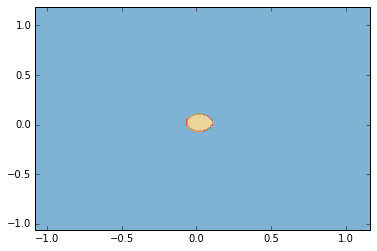

In [20]:
X = np.array((up_up_data, down_down_data)).transpose()
y = list(np.ones(len(up_up_valid_scores))) + list(np.zeros(len(up_up_intruder_scores)))

svc = svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05, kernel="rbf", gamma=0.1).fit(X)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Up up')
plt.ylabel('Down down')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
X = np.array((up_up_data, down_up_data)).transpose()
y = list(np.ones(len(up_up_valid_scores))) + list(np.zeros(len(up_up_intruder_scores)))

svc = svm.SVC(kernel=kernel, gamma=gamma, C=C).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Up Up')
plt.ylabel('Down up')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
X = np.array((down_down_data, down_up_data)).transpose()
y = list(np.ones(len(down_down_valid_scores))) + list(np.zeros(len(down_down_intruder_scores)))

svc = svm.SVC(kernel=kernel, gamma=gamma, C=C).fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.7)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Down down')
plt.ylabel('Down up')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## Functions

In [33]:
def sample_dist(sample_val, mean, std_dev):
    return (sample_val - mean)/float(std_dev)

def get_scores(up_up_sample, down_down_sample, down_up_sample, 
               up_up_mean_list, up_up_std_dev_list, 
               down_down_mean_list, down_down_std_dev_list, 
               down_up_mean_list, down_up_std_dev_list):
    
    up_up_score = 0
    down_down_score = 0
    down_up_score = 0

    for i in range(0, len(up_up_sample)):
        up_up_score = up_up_score + sample_dist(up_up_sample[i], up_up_mean_list[i], up_up_std_dev_list[i])
    
    for i in range(0, len(down_down_sample)):
        down_down_score = down_down_score + sample_dist(down_down_sample[i], down_down_mean_list[i], down_down_std_dev_list[i])
    
    for i in range(0, len(down_up_sample)):
        down_up_score = down_up_score + sample_dist(down_up_sample[i], down_up_mean_list[i], down_up_std_dev_list[i])
    
    up_up_score = up_up_score/number_of_samples
    down_down_score = down_down_score/number_of_samples
    down_up_score = down_up_score/number_of_samples
    
    return (up_up_score, down_down_score, down_up_score)

def get_model(key_up_data, key_down_data):
    
    assert len(key_up_data) == len(key_down_data)
    assert len(key_up_data[0]) == len(key_down_data[0])
    
    number_of_samples = len(key_up_data)
    number_of_keys = len(key_up_data[0])
    
    assert number_of_samples > 10, 'Need minimum 10 typing samples to make accurate predictions.'
    
    up_up_data = []
    down_down_data = []
    down_up_data = []
    
    for i in range(0, number_of_samples):
        up_up_arr = get_consecutive_diff(key_up_data[i])
        down_down_arr = get_consecutive_diff(key_down_data[i])
        down_up_arr = get_arr_diff(key_down_data[i], key_up_data[i])
        
        up_up_data.append(up_up_arr)
        down_down_data.append(down_down_arr)
        down_up_data.append(down_up_arr)
        
    up_up_mean_list = []
    up_up_std_dev_list = []
    
    down_down_mean_list = []
    down_down_std_dev_list = []
    
    down_up_mean_list = []
    down_up_std_dev_list = []
    
    df = pd.DataFrame(up_up_data, 
                      index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                      columns=['key_' + str(x) for x in range(1, number_of_keys)])
    for key in list(df.columns.values):
        up_up_mean_list.append(np.mean(df[key]))
        up_up_std_dev_list.append(np.std(df[key]))
        
    df = pd.DataFrame(down_down_data, 
                  index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                  columns=['key_' + str(x) for x in range(1, number_of_keys)])
    for key in list(df.columns.values):
        down_down_mean_list.append(np.mean(df[key]))
        down_down_std_dev_list.append(np.std(df[key]))
        
    df = pd.DataFrame(down_up_data, 
                  index=['sample_' + str(x) for x in range(1, number_of_samples+1)], 
                  columns=['key_' + str(x) for x in range(1, number_of_keys+1)]) # since down_up data has one extra 
    for key in list(df.columns.values):
        down_up_mean_list.append(np.mean(df[key]))
        down_up_std_dev_list.append(np.std(df[key]))
        
    up_up_valid_scores = []
    down_down_valid_scores = []
    down_up_valid_scores = []
    
    for i in range(0, number_of_samples):
        up_up_sample = get_consecutive_diff(key_up_data[i])
        down_down_sample = get_consecutive_diff(key_down_data[i])
        down_up_sample = get_arr_diff(key_down_data[i], key_up_data[i])
        
        (up_up_score, down_down_score, down_up_score) = get_scores(
                                                            up_up_sample, down_down_sample,down_up_sample,
                                                            up_up_mean_list, up_up_std_dev_list,
                                                            down_down_mean_list, down_down_std_dev_list,
                                                            down_up_mean_list, down_up_std_dev_list
                                                        )    
        up_up_valid_scores.append(up_up_score)
        down_down_valid_scores.append(down_down_score)
        down_up_valid_scores.append(down_up_score)
    
    return (up_up_mean_list, up_up_std_dev_list, 
            down_down_mean_list, down_down_std_dev_list,
            down_up_mean_list, down_up_std_dev_list,
            up_up_valid_scores, down_down_valid_scores, down_up_valid_scores)

def validate_sample(key_up_events, key_down_events,
                    up_up_mean_list, up_up_std_dev_list,
                    down_down_mean_list, down_down_std_dev_list,
                    down_up_mean_list, down_up_std_dev_list,
                    up_up_valid_scores, down_down_valid_scores, down_up_valid_scores,
                    maximum_number_of_std_deviations_from_mean):
    
    assert len(key_up_events) == len(key_down_events), 'Length of KeyUp and KeyDown events do not match'
    
    up_up_threshold = np.mean(up_up_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(up_up_valid_scores)
    down_down_threshold = np.mean(down_down_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(down_down_valid_scores)
    down_up_threshold = np.mean(down_up_valid_scores) + maximum_number_of_std_deviations_from_mean*np.std(down_up_valid_scores)
    
    up_up_arr = get_consecutive_diff(key_up_events)
    down_down_arr = get_consecutive_diff(key_down_events)
    down_up_arr = get_arr_diff(key_down_events, key_up_events)
    
    (up_up_score, down_down_score, down_up_score) = get_scores(
                                                                up_up_arr, down_down_arr, down_up_arr, 
                                                                up_up_mean_list, up_up_std_dev_list, 
                                                                down_down_mean_list, down_down_std_dev_list, 
                                                                down_up_mean_list, down_up_std_dev_list
                                                              )
    
    if up_up_score > up_up_threshold or down_down_score > down_down_threshold or down_up_score > down_up_threshold:
        return False
    else:
        return True
    

In [39]:
key_up_training_data = [
    [1473811850049, 1473811850096, 1473811850250, 1473811850385, 1473811850570, 1473811850681, 1473811850738, 1473811850921],
    [1473811851401, 1473811851441, 1473811851585, 1473811851729, 1473811851938, 1473811852033, 1473811852081, 1473811852250],
    [1473811852754, 1473811852791, 1473811852969, 1473811853122, 1473811853313, 1473811853425, 1473811853489, 1473811853665],
    [1473811854121, 1473811854193, 1473811854385, 1473811854538, 1473811854761, 1473811854850, 1473811854929, 1473811855121],
    [1473811857361, 1473811857417, 1473811857569, 1473811857705, 1473811857874, 1473811857985, 1473811858034, 1473811858193],
    [1473811858713, 1473811858761, 1473811858921, 1473811859082, 1473811859289, 1473811859338, 1473811859458, 1473811859649],
    [1473811860130, 1473811860185, 1473811860361, 1473811860505, 1473811860834, 1473811860961, 1473811861033, 1473811861225],
    [1473811861658, 1473811861705, 1473811861874, 1473811862017, 1473811862330, 1473811862497, 1473811862545, 1473811862746],
    [1473811863193, 1473811863241, 1473811863401, 1473811863545, 1473811863730, 1473811864345, 1473811864417, 1473811864617],
    [1473811865042, 1473811865072, 1473811865233, 1473811865353, 1473811865562, 1473811865673, 1473811865713, 1473811865977],
    [1473811866569, 1473811866609, 1473811866737, 1473811866897, 1473811867074, 1473811867233, 1473811867281, 1473811867489],
    [1473811868073, 1473811868145, 1473811868305, 1473811868442, 1473811868641, 1473811868730, 1473811868801, 1473811868993],
    [1473811869761, 1473811869830, 1473811870001, 1473811870137, 1473811870346, 1473811870409, 1473811870537, 1473811870913],
    [1473811871449, 1473811871497, 1473811871641, 1473811871777, 1473811871978, 1473811872490, 1473811872569, 1473811872761],
    [1473811873417, 1473811873465, 1473811873609, 1473811873753, 1473811873933, 1473811874034, 1473811874081, 1473811874250],
    [1473811874649, 1473811874689, 1473811874841, 1473811874969, 1473811875162, 1473811875249, 1473811875321, 1473811875481],
    [1473811875897, 1473811875929, 1473811876089, 1473811876241, 1473811876401, 1473811876522, 1473811876593, 1473811876769],
    [1473811877225, 1473811877257, 1473811877401, 1473811877545, 1473811877729, 1473811877817, 1473811877913, 1473811878089],
    [1473811878561, 1473811878601, 1473811878769, 1473811878921, 1473811879193, 1473811879457, 1473811879545, 1473811879730],
    [1473811880113, 1473811880153, 1473811880297, 1473811880457, 1473811880857, 1473811880977, 1473811881033, 1473811881225],
    [1473811881617, 1473811881649, 1473811881793, 1473811881945, 1473811882121, 1473811882241, 1473811882321, 1473811882505],
    [1473811883009, 1473811883056, 1473811883201, 1473811883337, 1473811883537, 1473811883634, 1473811883681, 1473811883841],
    [1473811884593, 1473811884633, 1473811884781, 1473811884937, 1473811885121, 1473811885217, 1473811885281, 1473811885457],
    [1473811886929, 1473811887000, 1473811887157, 1473811887297, 1473811887465, 1473811887577, 1473811887649, 1473811887825],
    [1473811888257, 1473811888296, 1473811888449, 1473811888601, 1473811888769, 1473811888873, 1473811888937, 1473811889113],
    [1473811889585, 1473811889648, 1473811889801, 1473811889953, 1473811890131, 1473811890249, 1473811890305, 1473811890489],
    [1473811890921, 1473811890943, 1473811891089, 1473811891241, 1473811891433, 1473811891521, 1473811891585, 1473811891768],
    [1473811892705, 1473811892816, 1473811892961, 1473811893113, 1473811893281, 1473811893385, 1473811893449, 1473811893617],
    [1473811896185, 1473811896216, 1473811896489, 1473811896921, 1473811897129, 1473811897241, 1473811897305, 1473811897465],
    [1473811898345, 1473811898360, 1473811898561, 1473811898745, 1473811898938, 1473811899017, 1473811899113, 1473811899296],
    [1473811900144, 1473811900160, 1473811900337, 1473811900473, 1473811900665, 1473811900753, 1473811900824, 1473811900960],
    [1473811902481, 1473811902568, 1473811902713, 1473811902849, 1473811903029, 1473811903121, 1473811903185, 1473811903377],
    [1473811904001, 1473811904062, 1473811904217, 1473811904353, 1473811904553, 1473811904633, 1473811904705, 1473811904888],
    [1473811907761, 1473811907793, 1473811907961, 1473811908113, 1473811908297, 1473811908377, 1473811908441, 1473811908641],
    [1473811909337, 1473811909384, 1473811909537, 1473811909680, 1473811909872, 1473811909953, 1473811910016, 1473811910184],
    [1473811912600, 1473811912632, 1473811912793, 1473811912937, 1473811913121, 1473811913225, 1473811913289, 1473811913480],
    [1473811914201, 1473811914280, 1473811914425, 1473811914569, 1473811914753, 1473811914840, 1473811914913, 1473811915080],
    [1473811915513, 1473811915560, 1473811915721, 1473811915889, 1473811916081, 1473811916153, 1473811916233, 1473811916424],
    [1473811916873, 1473811916912, 1473811917073, 1473811917217, 1473811917417, 1473811917513, 1473811917577, 1473811917769],
    [1473811918217, 1473811918264, 1473811918425, 1473811918568, 1473811918721, 1473811918848, 1473811918912, 1473811919096],
    [1473811919553, 1473811919584, 1473811919745, 1473811919897, 1473811920064, 1473811920160, 1473811920241, 1473811920424],
    [1473811920928, 1473811920952, 1473811921113, 1473811921257, 1473811921425, 1473811921512, 1473811921584, 1473811921777],
    [1473811922361, 1473811922400, 1473811922576, 1473811922753, 1473811922945, 1473811923057, 1473811923130, 1473811923297],
    [1473811923745, 1473811923749, 1473811923928, 1473811924081, 1473811924505, 1473811924696, 1473811925056, 1473811925248],
    [1473811925768, 1473811925773, 1473811925928, 1473811926080, 1473811926273, 1473811926376, 1473811926456, 1473811926625],
    [1473811927080, 1473811927084, 1473811927809, 1473811928224, 1473811928424, 1473811928544, 1473811928568, 1473811928752],
    [1473811929200, 1473811929215, 1473811929393, 1473811929536, 1473811930048, 1473811930214, 1473811930288, 1473811930472],
    [1473811930880, 1473811930895, 1473811931048, 1473811931209, 1473811931393, 1473811931505, 1473811931544, 1473811931721],
    [1473811932416, 1473811932444, 1473811932609, 1473811932753, 1473811932961, 1473811933040, 1473811933088, 1473811933280],
    [1473812034574, 1473812034630, 1473812034791, 1473812034951, 1473812035119, 1473812035207, 1473812035263, 1473812035430]
]

key_down_training_data = [
    [1473811849930, 1473811850051, 1473811850210, 1473811850330, 1473811850498, 1473811850594, 1473811850687, 1473811850826],
    [1473811851290, 1473811851378, 1473811851562, 1473811851674, 1473811851842, 1473811851943, 1473811852010, 1473811852178],
    [1473811852642, 1473811852755, 1473811852914, 1473811853066, 1473811853234, 1473811853338, 1473811853427, 1473811853578],
    [1473811854034, 1473811854123, 1473811854322, 1473811854466, 1473811854642, 1473811854762, 1473811854855, 1473811855010],
    [1473811857266, 1473811857366, 1473811857522, 1473811857658, 1473811857818, 1473811857898, 1473811857962, 1473811858122],
    [1473811858602, 1473811858714, 1473811858866, 1473811859018, 1473811859195, 1473811859266, 1473811859370, 1473811859553],
    [1473811860018, 1473811860131, 1473811860298, 1473811860458, 1473811860754, 1473811860874, 1473811860967, 1473811861122],
    [1473811861554, 1473811861662, 1473811861842, 1473811861962, 1473811862274, 1473811862418, 1473811862482, 1473811862651],
    [1473811863106, 1473811863195, 1473811863346, 1473811863498, 1473811863666, 1473811864258, 1473811864347, 1473811864522],
    [1473811864930, 1473811865010, 1473811865155, 1473811865266, 1473811865466, 1473811865610, 1473811865634, 1473811865866],
    [1473811866458, 1473811866530, 1473811866698, 1473811866842, 1473811867018, 1473811867162, 1473811867210, 1473811867402],
    [1473811867978, 1473811868089, 1473811868258, 1473811868394, 1473811868554, 1473811868643, 1473811868734, 1473811868897],
    [1473811869682, 1473811869793, 1473811869946, 1473811870090, 1473811870250, 1473811870351, 1473811870466, 1473811870810],
    [1473811871346, 1473811871417, 1473811871586, 1473811871730, 1473811871914, 1473811872402, 1473811872494, 1473811872682],
    [1473811873314, 1473811873394, 1473811873546, 1473811873689, 1473811873850, 1473811873954, 1473811874039, 1473811874170],
    [1473811874562, 1473811874654, 1473811874781, 1473811874922, 1473811875090, 1473811875167, 1473811875266, 1473811875409],
    [1473811875802, 1473811875902, 1473811876034, 1473811876178, 1473811876346, 1473811876442, 1473811876527, 1473811876706],
    [1473811877131, 1473811877186, 1473811877354, 1473811877498, 1473811877674, 1473811877735, 1473811877842, 1473811878009],
    [1473811878466, 1473811878566, 1473811878714, 1473811878858, 1473811879082, 1473811879370, 1473811879490, 1473811879658],
    [1473811880026, 1473811880081, 1473811880250, 1473811880394, 1473811880778, 1473811880890, 1473811880954, 1473811881137],
    [1473811881522, 1473811881586, 1473811881730, 1473811881873, 1473811882050, 1473811882162, 1473811882243, 1473811882409],
    [1473811882938, 1473811883014, 1473811883154, 1473811883282, 1473811883442, 1473811883546, 1473811883639, 1473811883769],
    [1473811884506, 1473811884596, 1473811884729, 1473811884882, 1473811885050, 1473811885146, 1473811885222, 1473811885378],
    [1473811886810, 1473811886934, 1473811887106, 1473811887234, 1473811887393, 1473811887489, 1473811887562, 1473811887729],
    [1473811888154, 1473811888241, 1473811888393, 1473811888538, 1473811888702, 1473811888793, 1473811888866, 1473811889026],
    [1473811889474, 1473811889590, 1473811889762, 1473811889905, 1473811890065, 1473811890154, 1473811890251, 1473811890401],
    [1473811890834, 1473811890881, 1473811891042, 1473811891186, 1473811891346, 1473811891449, 1473811891526, 1473811891689],
    [1473811892609, 1473811892753, 1473811892914, 1473811893049, 1473811893218, 1473811893305, 1473811893390, 1473811893537],
    [1473811896073, 1473811896145, 1473811896297, 1473811896834, 1473811897034, 1473811897161, 1473811897242, 1473811897385],
    [1473811898242, 1473811898321, 1473811898498, 1473811898666, 1473811898841, 1473811898943, 1473811899041, 1473811899209],
    [1473811900033, 1473811900113, 1473811900290, 1473811900433, 1473811900586, 1473811900689, 1473811900757, 1473811900905],
    [1473811902385, 1473811902505, 1473811902657, 1473811902797, 1473811902953, 1473811903041, 1473811903125, 1473811903281],
    [1473811903905, 1473811904005, 1473811904169, 1473811904297, 1473811904465, 1473811904558, 1473811904635, 1473811904793],
    [1473811907658, 1473811907729, 1473811907889, 1473811908051, 1473811908193, 1473811908302, 1473811908353, 1473811908529],
    [1473811909241, 1473811909342, 1473811909481, 1473811909625, 1473811909777, 1473811909874, 1473811909930, 1473811910105],
    [1473811912489, 1473811912553, 1473811912721, 1473811912873, 1473811913033, 1473811913122, 1473811913230, 1473811913385],
    [1473811914125, 1473811914206, 1473811914369, 1473811914513, 1473811914665, 1473811914754, 1473811914842, 1473811914993],
    [1473811915401, 1473811915517, 1473811915673, 1473811915809, 1473811915985, 1473811916085, 1473811916158, 1473811916329],
    [1473811916770, 1473811916841, 1473811917017, 1473811917154, 1473811917305, 1473811917422, 1473811917517, 1473811917665],
    [1473811918137, 1473811918222, 1473811918369, 1473811918513, 1473811918670, 1473811918761, 1473811918854, 1473811919001],
    [1473811919450, 1473811919556, 1473811919697, 1473811919858, 1473811920009, 1473811920089, 1473811920177, 1473811920329],
    [1473811920817, 1473811920905, 1473811921057, 1473811921217, 1473811921353, 1473811921430, 1473811921529, 1473811921681],
    [1473811922241, 1473811922365, 1473811922513, 1473811922673, 1473811922865, 1473811922969, 1473811923062, 1473811923201],
    [1473811923617, 1473811923689, 1473811923849, 1473811923977, 1473811924441, 1473811924633, 1473811924985, 1473811925157],
    [1473811925649, 1473811925713, 1473811925857, 1473811926009, 1473811926189, 1473811926297, 1473811926380, 1473811926553],
    [1473811926978, 1473811927017, 1473811927657, 1473811928145, 1473811928353, 1473811928465, 1473811928521, 1473811928673],
    [1473811929097, 1473811929145, 1473811929305, 1473811929457, 1473811929953, 1473811930137, 1473811930215, 1473811930393],
    [1473811930777, 1473811930833, 1473811930985, 1473811931133, 1473811931314, 1473811931425, 1473811931510, 1473811931649],
    [1473811932313, 1473811932384, 1473811932537, 1473811932690, 1473811932841, 1473811932966, 1473811933042, 1473811933177],
    [1473812034463, 1473812034579, 1473812034735, 1473812034891, 1473812035031, 1473812035124, 1473812035212, 1473812035343]
]
    
(up_up_mean_list, up_up_std_dev_list, 
 down_down_mean_list, down_down_std_dev_list,
 down_up_mean_list, down_up_std_dev_list,
 up_up_valid_scores, down_down_valid_scores, down_up_valid_scores) = get_model(key_up_training_data, key_down_training_data)

new_key_up_sample = [1473811851401, 1473811851441, 1473811851585, 1473811851729, 1473811851938, 1473811852033, 1473811852081, 1473811852250]
new_key_down_sample = [1473811851290, 1473811851378, 1473811851562, 1473811851674, 1473811851842, 1473811851943, 1473811852010, 1473811852178]

maximum_number_of_std_deviations_from_mean = 3
validate_sample(new_key_up_sample, new_key_down_sample,
                    up_up_mean_list, up_up_std_dev_list,
                    down_down_mean_list, down_down_std_dev_list,
                    down_up_mean_list, down_up_std_dev_list,
                    up_up_valid_scores, down_down_valid_scores, down_up_valid_scores,
                    maximum_number_of_std_deviations_from_mean)

True

## Thomas's Cadence Analysis - Work in Progress

In [19]:
down_arr = [1475715925625,1475715925777,1475715926065,1475715926225,1475715926401,1475715926561,1475715926665,1475715926809]
up_arr = [1475715925705,1475715925849,1475715926137,1475715926305,1475715926513,1475715926641,1475715926737,1475715926881]

up_up_arr = get_consecutive_diff(up_arr)
down_down_arr = get_consecutive_diff(down_arr)
down_up_arr = get_arr_diff(down_arr, up_arr)
    
(up_up_score, down_down_score, down_up_score) = get_scores(up_up_arr, down_down_arr, down_up_arr)

print 'Up up score:', up_up_score
print 'Down down score:', down_down_score
print 'Down up score:', down_up_score

datapoint = np.array((up_up_score, down_down_score, down_up_score)).reshape(1, -1)
print svc.predict(datapoint)

Up up score: 0.11199954104
Down down score: 0.0878321369315
Down up score: 0.0474776212899
[ 0.]


In [39]:
data = pd.read_clipboard()
data

,Name/ID,down_events,ip,up_events
0,id=5066549580791808,NaN,NaN,NaN
1,"1475716025121,1475716025257,1475716025577,1475...",NaN,NaN,NaN
2,98.234.191.13,NaN,NaN,NaN
3,"1475716025193,1475716025393,1475716025657,1475...",NaN,NaN,NaN
4,id=5069036098420736,NaN,NaN,NaN
5,"1475715969446,1475715969566,1475715969798,1475...",NaN,NaN,NaN
6,98.234.191.13,NaN,NaN,NaN
7,"1475715969525,1475715969653,1475715969869,1475...",NaN,NaN,NaN
8,id=5071522616049664,NaN,NaN,NaN
9,"1475715624299,1475715624475,1475715624707,1475...",NaN,NaN,NaN


In [60]:
#data = data['Name/ID'].values.reshape(46, 4)
#df = pd.DataFrame({'id':data[:,0],'down_events':data[:,1],'ip':data[:,2],'up_events':data[:,3]})
df

for idx, row in df.iterrows():
    down_arr = [int(x) for x in row['down_events'].split(',')]
    up_arr = [int(x) for x in row['up_events'].split(',')]

    up_up_arr = get_consecutive_diff(up_arr)
    down_down_arr = get_consecutive_diff(down_arr)
    down_up_arr = get_arr_diff(down_arr, up_arr)
    
    (up_up_score, down_down_score, down_up_score) = get_scores(up_up_arr, down_down_arr, down_up_arr)

    #print 'Up up score:', up_up_score
    #print 'Down down score:', down_down_score
    #print 'Down up score:', down_up_score

    datapoint = np.array((up_up_score, down_down_score, down_up_score)).reshape(1, -1)
    print svc.predict(datapoint)

[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 1.]
[ 1.]
[ 0.]
[ 0.]
[ 1.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
[ 0.]
